# Uncertainty Quantification Metrics Demo

This notebook demonstrates and explains the most important metrics for evaluating regression models with uncertainty intervals. Each metric is defined mathematically and illustrated with a simple example.

## Root Mean Squared Error (RMSE)

The Root Mean Squared Error (RMSE) measures the average magnitude of the errors between predicted means and true values. It is a standard metric for regression accuracy.

**Formula:**

$$
\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

where $\hat{y}_i$ is the predicted mean and $y_i$ is the true value.

**Interpretation:** Lower RMSE indicates better point prediction accuracy.

## Coverage

Coverage measures the proportion of true values that fall within the predicted uncertainty intervals. It is a key metric for interval calibration.

**Formula:**

$$
\mathrm{Coverage} = \frac{1}{n} \sum_{i=1}^n \mathbb{I}\{l_i \leq y_i \leq u_i\}
$$

where $l_i$ and $u_i$ are the lower and upper bounds of the prediction interval, and $\mathbb{I}$ is the indicator function.

**Interpretation:** For a nominal $1-\alpha$ confidence level, coverage should be close to $1-\alpha$.

## Average Interval Width

The average interval width measures the mean width of the predicted uncertainty intervals.

**Formula:**

$$
\mathrm{Average\ Interval\ Width} = \frac{1}{n} \sum_{i=1}^n (u_i - l_i)
$$

where $u_i$ and $l_i$ are the upper and lower bounds of the prediction interval.

**Interpretation:** Lower interval width is better if coverage is maintained, as it indicates more precise uncertainty estimates.

## Interval Score

The interval score is a proper scoring rule for evaluating prediction intervals. It penalizes both the width of the interval and whether the true value falls outside the interval.

**Formula:**

$$
\mathrm{Interval\ Score}_i = (u_i - l_i) + \frac{2}{\alpha}(l_i - y_i)\mathbb{I}\{y_i < l_i\} + \frac{2}{\alpha}(y_i - u_i)\mathbb{I}\{y_i > u_i\}
$$

where $u_i$ and $l_i$ are the upper and lower bounds, $y_i$ is the true value, $\alpha$ is the miscoverage rate, and $\mathbb{I}$ is the indicator function.

**Interpretation:** Lower interval score is better. It rewards narrow intervals that contain the true value and penalizes intervals that miss the true value.

## Negative Log Likelihood (NLL)

The negative log likelihood (NLL) measures how well a probabilistic model predicts the observed data, assuming a Gaussian distribution for the predictions.

**Formula:**

$$
\mathrm{NLL} = \frac{1}{n} \sum_{i=1}^n \left[ \frac{1}{2} \log(2\pi \sigma_i^2) + \frac{(y_i - \mu_i)^2}{2\sigma_i^2} \right]
$$

where $\mu_i$ is the predicted mean, $\sigma_i^2$ is the predicted variance, and $y_i$ is the true value.

**Interpretation:** Lower NLL indicates better probabilistic predictions.

## Error Width Correlation

The error width correlation is the Pearson correlation coefficient between the absolute residuals and the predicted interval widths. It measures how well the predicted uncertainty adapts to the actual errors.

**Formula:**

$$
\mathrm{Corr}(|y_i - \hat{y}_i|, u_i - l_i)
$$

where $|y_i - \hat{y}_i|$ is the absolute error and $u_i - l_i$ is the predicted interval width.

The Pearson correlation coefficient between two variables $X$ and $Y$ is defined as:

$$
\rho_{X,Y} = \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^n (Y_i - \bar{Y})^2}}
$$

**Interpretation:**
- A value near 1 means the model's uncertainty intervals adapt well to the actual errors (good calibration).
- A value near 0 means little relationship between predicted uncertainty and actual error.

## Group Conditional Coverage Metrics
These metrics evaluate how well the model's uncertainty intervals are calibrated across different regions of the data, by dividing the data into bins (groups) and computing coverage within each bin.

**Root Mean Square Coverage Deviation (RMSCD):**
- RMSCD measures the root mean square deviation between the empirical coverage in each bin and the nominal coverage $(1-\alpha)$.
- Lower RMSCD means coverage is more uniform across all bins (better conditional calibration).
- **Formula:**

  $$
  \mathrm{RMSCD} = \sqrt{\frac{1}{B} \sum_{b=1}^B (\hat{C}_b - (1-\alpha))^2}
  $$

  where $\hat{C}_b$ is the empirical coverage in bin $b$, and $B$ is the number of bins.

**RMSCD_under:**
- RMSCD_under is the same as RMSCD, but only computed over bins where the empirical coverage is *below* the nominal coverage $(1-\alpha)$.
- This highlights regions where the model is under-covering (intervals are too narrow).
- **Formula:**

  $$
  \mathrm{RMSCD}_{\text{under}} = \sqrt{\frac{1}{|U|} \sum_{b \in U} (\hat{C}_b - (1-\alpha))^2}
  $$

  where $U$ is the set of bins with $\hat{C}_b < 1-\alpha$.

**Lowest Group Coverage:**
- The lowest group coverage is the minimum empirical coverage across all bins.
- This metric identifies the worst-case region in terms of coverage.
- **Formula:**

  $$
  \min_b \hat{C}_b
  $$
  
  where $\hat{C}_b$ is the empirical coverage in bin $b$.

## Example: Heteroskedastic Noise
We generate a simple sine wave with Heteroskedastic noise, and demonstrate how the metrics change when using a constant as opposed to adaptive method of uncertainty quantification. 

In [18]:
# Example: Generate synthetic regression data (sine wave with heteroskedastic noise) and prediction intervals
import numpy as np
np.random.seed(0)

n = 200
X = np.linspace(0, 1, n)
y_true = np.sin(2 * np.pi * X) + np.random.normal(0, 0.5 * X / np.max(X), n)

# Simulate predictions (mean is noiseless sine)
mean_pred = np.sin(2 * np.pi * X)

# --- Constant interval ---
# Use a fixed width chosen to achieve ~90% coverage
const_width = 2.0  # initial guess, will calibrate below
lower_const = mean_pred - const_width / 2
upper_const = mean_pred + const_width / 2

# --- Adaptive interval ---
# Make interval width proportional to noise std (unknown in practice, but for demo)
noise_std = 0.5 * X / np.max(X)
base_width = 2 * 1.645 * np.mean(noise_std)  # scale to match nominal 90% coverage
width_adapt = 2 * 1.645 * noise_std
lower_adapt = mean_pred - width_adapt / 2
upper_adapt = mean_pred + width_adapt / 2

# Calibrate constant width to match adaptive coverage
from scipy.optimize import minimize_scalar
def coverage_for_width(w):
    l = mean_pred - w/2
    u = mean_pred + w/2
    return np.abs(np.mean((y_true >= l) & (y_true <= u)) - 0.9)
res = minimize_scalar(coverage_for_width, bounds=(0.1, 5), method='bounded')
const_width = res.x
lower_const = mean_pred - const_width / 2
upper_const = mean_pred + const_width / 2

# Check actual coverages
cov_const = np.mean((y_true >= lower_const) & (y_true <= upper_const))
cov_adapt = np.mean((y_true >= lower_adapt) & (y_true <= upper_adapt))
print(f"Constant interval coverage: {cov_const:.3f}")
print(f"Adaptive interval coverage: {cov_adapt:.3f}")


Constant interval coverage: 0.890
Adaptive interval coverage: 0.895


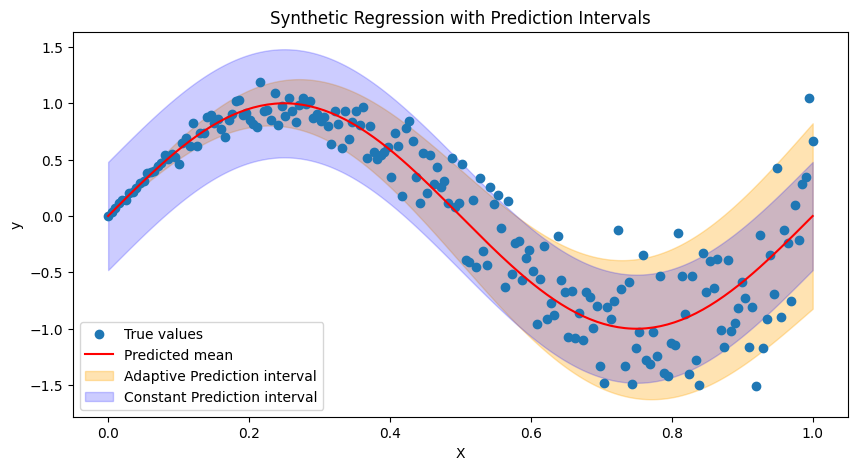

In [19]:
# Visualize predictions and intervals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(X, y_true, 'o', label='True values')
plt.plot(X, mean_pred, 'r-', label='Predicted mean')
plt.fill_between(X, lower_adapt, upper_adapt, color='orange', alpha=0.3, label='Adaptive Prediction interval')
plt.fill_between(X, lower_const, upper_const, color='blue', alpha=0.2, label='Constant Prediction interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Regression with Prediction Intervals')
plt.legend()
plt.show()

Constant metrics:
    rmse: 0.2931
    coverage: 0.8900
    average_interval_width: 0.9594
    interval_score: 1.0326
    nll_gaussian: 0.1916
    error_width_corr: -0.0368
    RMSCD: 0.0975
    RMSCD_under: 0.1581
    lowest_group_coverage: 0.6500
----------------
Adaptive metrics:
    rmse: 0.2931
    coverage: 0.8950
    average_interval_width: 0.8225
    interval_score: 0.8546
    nll_gaussian: -0.3006
    error_width_corr: 0.6207
    RMSCD: 0.0975
    RMSCD_under: 0.1323
    lowest_group_coverage: 0.6500
----------------


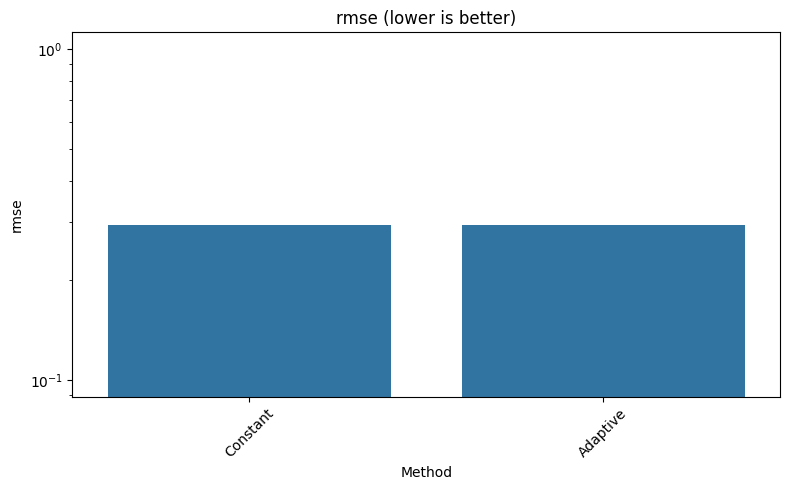

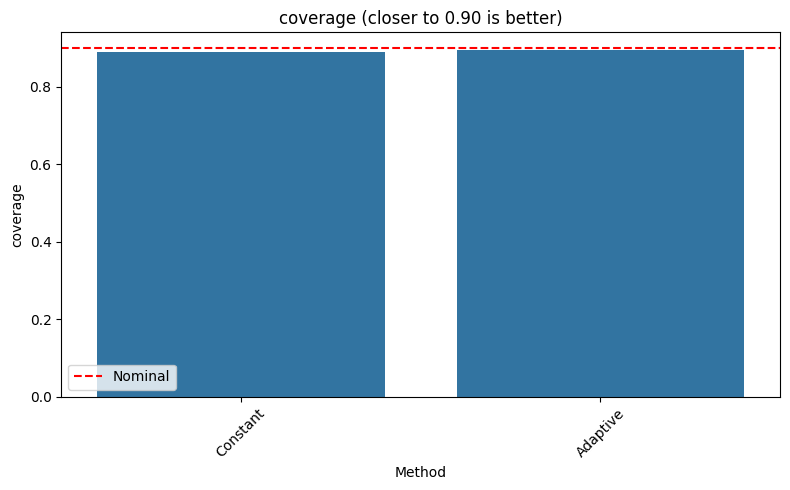

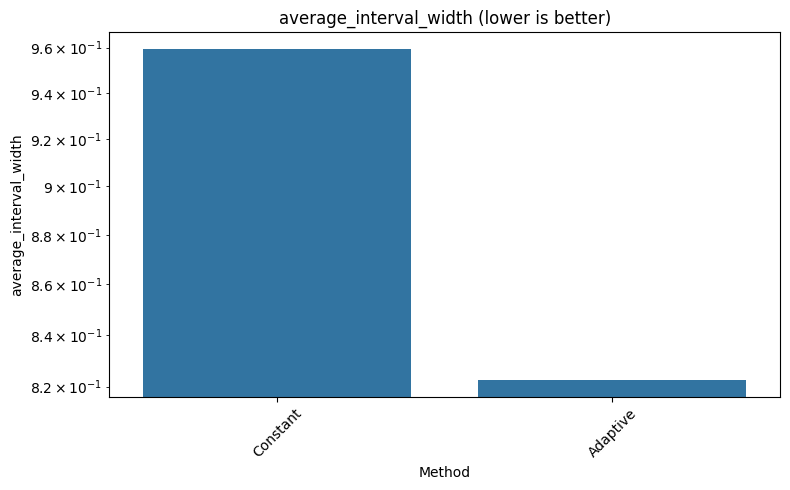

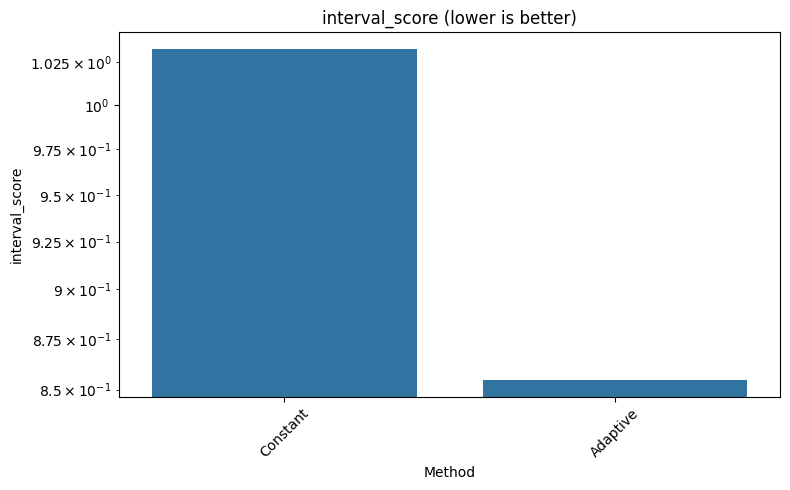

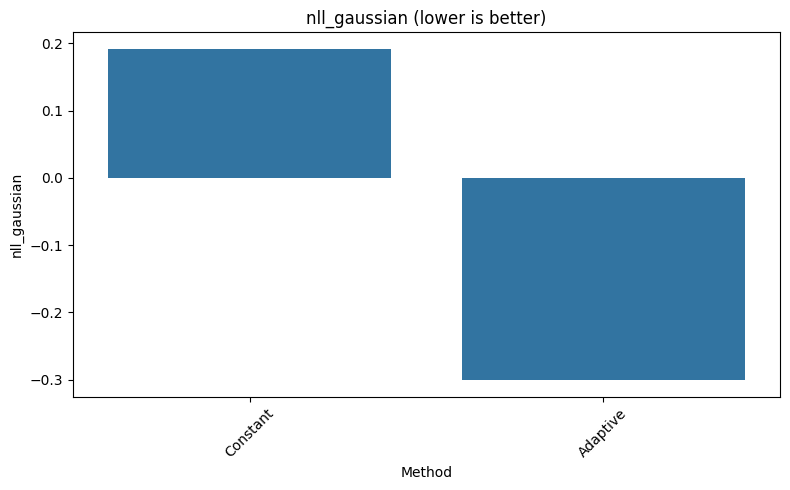

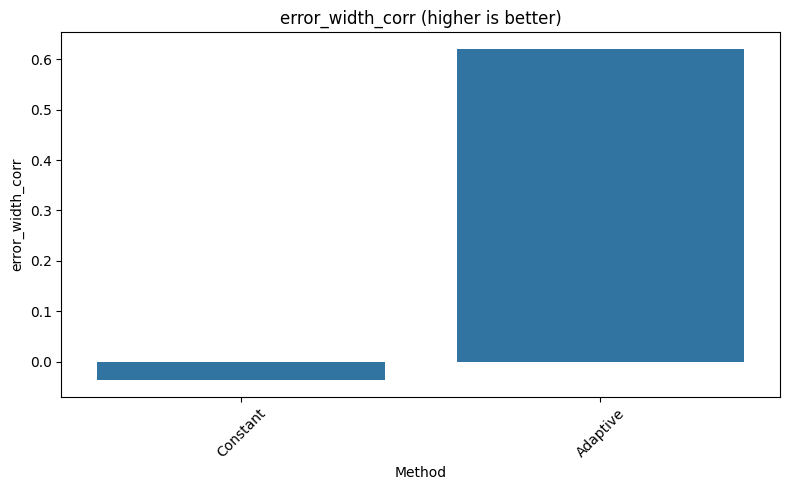

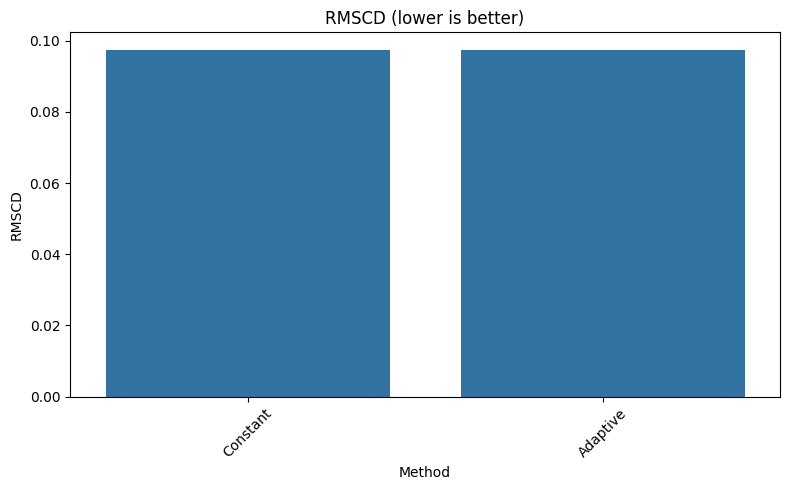

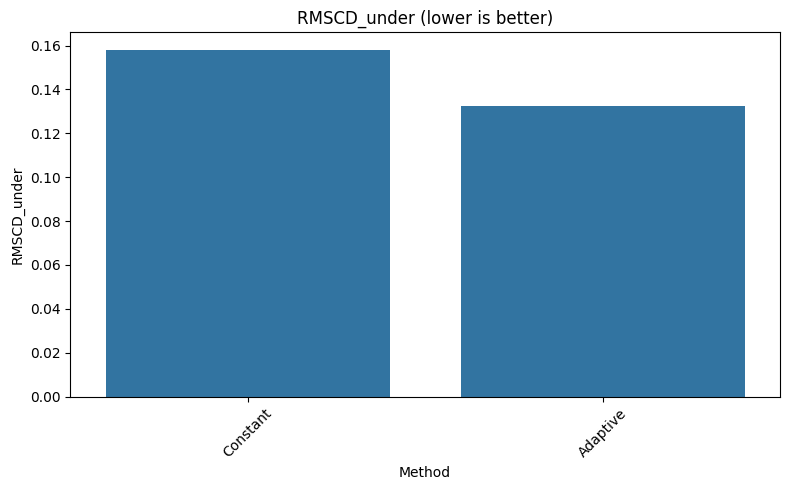

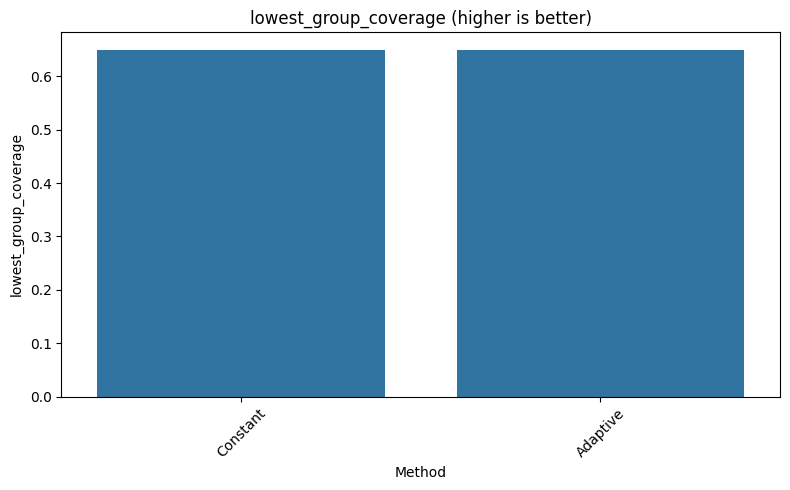

In [22]:
# Compute and display UQ metrics using UQRegressors utilities
from uqregressors.metrics.metrics import compute_all_metrics
from uqregressors.plotting.plotting import plot_metrics_comparisons

# Prepare solution_dict for plotting: method name -> (mean, lower, upper)
solution_dict = {
    'Constant': (mean_pred, lower_const, upper_const),
    'Adaptive': (mean_pred, lower_adapt, upper_adapt)
}

# Compute and print all metrics for both
alpha = 0.1
for method, (mean, lower, upper) in solution_dict.items():
    metrics = compute_all_metrics(mean, lower, upper, y_true, alpha)
    print(f"{method} metrics:")
    for k, v in metrics.items():
        print(f"    {k}: {v:.4f}")
    print(f"----------------")
# Plot metrics comparison
plot_metrics_comparisons(solution_dict, y_true, alpha, show=True)

## Analysis of results
Here we can see that although the target coverage is similar for both constant and adaptive width methods, the average interval width is slightly smaller for the adaptive method. This indicates that the adaptive method produces more informative intervals. Additionally, the correlation and log-likelihood metrics prioritize adaptivity of intervals, so both of those metrics are significantly better for the adaptive method. Note that the conditional coverage metrics in this case are similar for the two methods. However, this is due to the construction of the conditional coverage metrics in that they bin results based on their y-values, where the noise is truly heteroskedastic in their x-values. It is clear from the visualization that the adaptive method provides better conditional coverage, and this would be reflected in the metrics if binning was done by the input features as opposed to the output features. 